In [175]:
import sqlite3

import numpy as np
import pandas as pd
from typing import *
import ast

import torch
from torch_geometric.data import HeteroData
from bs4 import BeautifulSoup
from post_embedding_builder import PostEmbedding
import networkx as nx
from matplotlib import pyplot as plt

In [176]:
# Create your connection.
db = sqlite3.connect('../stackoverflow.db')

In [177]:
user_id = 13009

In [178]:
questions_df = pd.read_sql_query(f"""
        SELECT *
        FROM Post
        WHERE Tags LIKE '%python%' AND (PostTypeId = 1) AND ((LastEditorUserId = {user_id}) OR (OwnerUserId = {user_id}))
""", db)
questions_df.set_index('PostId', inplace=True)
questions_df

,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,CommunityOwnedDate,ContentLicense,ParentId
PostId,,,,,,,,,,,,,,,,,,
269676,1,NaN,2008-11-06T18:06:13.213,10,7250,<p>I want to make my Python library working wi...,13009,13009.0,Greg,2008-11-10T15:12:18.133,How can I Cause a Deadlock in MySQL for Testin...,<python><mysql><database><deadlock>,5,0,3.0,None,CC BY-SA 2.5,None
1046474,1,1046522.0,2009-06-25T22:04:16.890,5,12418,<p>How do I run this command with subprocess?<...,13009,13009.0,None,2009-06-25T22:21:41.520,Python - Subprocess - How to call a Piped comm...,<python><subprocess><pipe><echo><popen>,2,2,3.0,None,CC BY-SA 2.5,None
2970045,1,2974177.0,2010-06-03T21:52:14.793,6,7850,<p>I have a python web application that needs ...,13009,13009.0,None,2010-06-03T22:11:27.260,Python - Launch a Long Running Process from a ...,<python><windows><winapi><popen><long-running-...,4,2,6.0,None,CC BY-SA 2.5,None
3712445,1,3712645.0,2010-09-14T20:04:19.940,1,405,<p>Say I have text 'C:\somedir\test.log' and I...,13009,13009.0,None,2010-09-14T20:18:32.083,Python Regular Expression Question,<python><regex>,4,0,1.0,None,CC BY-SA 2.5,None
5538814,1,5539724.0,2011-04-04T13:00:53.620,0,631,"<p>I have multiple Django apps, and I have som...",13009,13009.0,None,2011-04-04T13:15:37.903,Django - non app specific models.py?,<python><django><django-models>,3,0,1.0,None,CC BY-SA 2.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36922532,1,36922586.0,2016-04-28T18:18:49.007,6,3284,<p>I know there must be a way to do this. But...,13009,NaN,None,None,Python functools.partial - How to apply it to ...,<python><static-methods><python-decorators><fu...,3,0,1.0,None,CC BY-SA 3.0,None
40749339,1,40749648.0,2016-11-22T18:42:04.867,1,1271,<p>Say I have a script like this:</p>\n\n<pre>...,13009,NaN,None,None,Python subprocess - check exit codes of forked...,<python><subprocess><fork>,1,0,NaN,None,CC BY-SA 3.0,None
41616578,1,41623932.0,2017-01-12T15:10:45.340,2,24094,<p>I'm trying to run code like this:</p>\n\n<p...,13009,NaN,None,None,Psycopg copy_expert method - How to use properly,<python><postgresql><psycopg2><psycopg>,2,2,NaN,None,CC BY-SA 3.0,None


In [179]:
answers_df = pd.read_sql_query(f"""
        SELECT A.Tags, B.*
        FROM Post A
            INNER JOIN Post B ON (B.ParentId = A.PostId) AND (B.ParentId IS NOT NULL)
        WHERE A.Tags LIKE '%python%' AND (B.PostTypeId = 2) AND ((B.LastEditorUserId = {user_id}) OR (B.OwnerUserId = {user_id}))
""", db)
answers_df = answers_df.loc[:,~answers_df.columns.duplicated()].copy()
answers_df.set_index('PostId', inplace=True)
answers_df

,Tags,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,Title,AnswerCount,CommentCount,FavoriteCount,CommunityOwnedDate,ContentLicense,ParentId
PostId,,,,,,,,,,,,,,,,,,
6930808,<python><django><django-models><django-admin><...,2,None,2011-08-03T17:45:24.243,1,None,"<p>Well, here's a work around since I can't fi...",13009,13009.0,None,2011-08-04T11:44:00.257,None,None,0,None,None,CC BY-SA 3.0,6913166
45239952,<python><django><migration><django-migrations>,2,None,2017-07-21T14:15:08.280,6,None,<p>Looks like I just needed to get User the sa...,13009,13009.0,None,2017-07-21T19:13:22.417,None,None,0,None,None,CC BY-SA 3.0,45238835
74335,<python><amazon>,2,None,2008-09-16T16:40:08.743,2,None,<p>pyaws seems to be the best one out there. ...,13009,NaN,None,None,None,None,0,None,None,CC BY-SA 2.5,48884
94627,<python><user-interface><api>,2,None,2008-09-18T17:21:42.810,3,None,"<p><a href=""http://pythoncard.sourceforge.net/...",13009,216356.0,None,2012-08-09T19:47:56.843,None,None,1,None,None,CC BY-SA 3.0,93930
109724,<python><excel><xlwt><pyexcelerator>,2,None,2008-09-20T23:10:13.863,2,None,"<p>Found example here: <a href=""http://www.ans...",13009,NaN,None,None,None,None,1,None,None,CC BY-SA 2.5,108134
207065,<python><ajax><screen-scraping><beautifulsoup>,2,None,2008-10-16T00:58:10.813,0,None,<p>This seems like it's a pretty common proble...,13009,NaN,None,None,None,None,1,None,None,CC BY-SA 2.5,206855
207074,<python><soap><soap-client>,2,None,2008-10-16T01:00:24.800,1,None,"<p>As I suggested <a href=""https://stackoverfl...",13009,-1.0,None,2017-05-23T12:34:59.060,None,None,0,None,None,CC BY-SA 2.5,206154
224014,<python><ruby><perl><text-parsing>,2,None,2008-10-22T00:03:23.323,5,None,"<p><a href=""http://pyparsing.wikispaces.com/"" ...",13009,NaN,None,None,None,None,0,None,None,CC BY-SA 2.5,223866
273994,<python><programming-languages><python-3.x>,2,None,2008-11-07T23:29:44.590,4,None,<p>Wouldn't VB6 to VB.net be the biggest examp...,13009,NaN,None,None,None,None,3,None,None,CC BY-SA 2.5,273524


In [180]:
comments_on_questions_df = pd.read_sql_query(f"""
        SELECT A.Tags, B.*
        FROM Post A
            INNER JOIN Comment B ON (B.PostId = A.PostId)
        WHERE A.Tags LIKE '%python%' AND (B.UserId = {user_id}) AND (A.PostTypeId = 1)
""", db)
comments_on_questions_df.set_index('CommentId', inplace=True)
comments_on_questions_df

,Tags,PostId,Score,Body,CreationDate,UserId,ContentLicense
CommentId,,,,,,,
857928,<python><subprocess><pipe><echo><popen>,1046474,0,"Yes, it runs from the windows dos console.",2009-06-25T22:15:13.437,13009,CC BY-SA 2.5
1513319,<python><django><forms><django-forms>,1640204,0,"lemonad, this would be at form creation time, ...",2009-10-29T12:44:20.160,13009,CC BY-SA 2.5
3029786,<python><windows><winapi><popen><long-running-...,2970045,0,Here are a few windows API commands that look ...,2010-06-03T22:10:42.643,13009,CC BY-SA 2.5
3421734,<python><permissions><authorization><decorator...,3302844,0,I don't think I want to use anything built-in....,2010-07-21T19:14:03.313,13009,CC BY-SA 2.5
6330991,<python><django><django-models><decimal><scien...,5566121,0,"4.08E+13 has two decimal places, I'm allowing ...",2011-04-06T12:26:33.123,13009,CC BY-SA 2.5
6331285,<python><django><django-models><decimal><scien...,5566121,0,I followed those instructions. I've tried all...,2011-04-06T12:43:15.377,13009,CC BY-SA 2.5
6774887,<python><database><migration><django-south>,5833418,4,"It's going to be pretty critical data, and hon...",2011-05-04T20:00:35.997,13009,CC BY-SA 3.0
8234046,<python><django><django-models><django-admin><...,6913166,1,I'm thinking I need to make a custom model fie...,2011-08-02T14:23:53.283,13009,CC BY-SA 3.0
8234115,<python><string-formatting><number-formatting>...,6913532,32,"nah, not at all. I wanted to separate this int...",2011-08-02T14:26:37.263,13009,CC BY-SA 3.0


In [181]:
comments_on_answers_df = pd.read_sql_query(f"""
    SELECT A.Tags, C.*
    FROM Post A
        INNER JOIN Post B ON (B.ParentId = A.PostId) AND (B.ParentId IS NOT NULL)
        INNER JOIN Comment C ON (B.PostId = C.PostId)
    WHERE A.Tags LIKE '%python%' AND (C.UserId = {user_id}) AND (B.PostTypeId = 2)
""", db)
comments_on_answers_df.set_index('CommentId', inplace=True)
comments_on_answers_df

,Tags,PostId,Score,Body,CreationDate,UserId,ContentLicense
CommentId,,,,,,,
27452,<python><memory-management><short>,120454,0,Can I use IIBTree without installing all of Zo...,2008-09-23T16:48:24.133,13009,CC BY-SA 2.5
30223,<python>,125052,0,Keep in mind there are some unpythonic idioms ...,2008-09-24T14:02:17.330,13009,CC BY-SA 2.5
63505,<python>,92318,0,What about iterators exactly?,2008-10-08T01:43:15.823,13009,CC BY-SA 2.5
124749,<python><mysql><database><deadlock>,270449,0,That would just cause a OperationalError: (120...,2008-11-06T22:10:52.610,13009,CC BY-SA 2.5
124761,<python><mysql><database><deadlock>,270492,0,How would I make sure they run at exactly the ...,2008-11-06T22:12:43.137,13009,CC BY-SA 2.5
...,...,...,...,...,...,...,...
68725297,<python><subprocess><fork>,40749648,0,Follow up question. What if the child finishe...,2016-11-22T19:04:27.827,13009,CC BY-SA 3.0
68725576,<python><subprocess><fork>,40749648,1,"Excellent thanks! From your article, I guess ...",2016-11-22T19:13:12.043,13009,CC BY-SA 3.0
70480473,<python><postgresql><psycopg2><psycopg>,41623932,0,"Yes, I verified that worked to remove the quot...",2017-01-13T17:35:23.640,13009,CC BY-SA 3.0


In [182]:
from post_embedding_builder import Import

In [183]:
from static_graph_construction import StaticGraphConstruction



# class StaticGraphConstruction:
#
#     def __init__(self):
#         self._known_tags = {}  # tag_name -> index
#         self._known_modules = {}  # module_name -> index
#         self._data = HeteroData()
#         self._post_embedding_builder = PostEmbedding()
#         self._first_n_tags = 3
#
#         self._tag_to_question_edges = []
#         self._tag_to_answer_edges = []
#         self._tag_to_comment_edges = []
#
#         self._module_to_question_edges = []
#         self._module_to_answer_edges = []
#         self._module_to_comment_edges = []
#
#
#     def process_questions(self, questions: pd.DataFrame) -> torch.Tensor:
#         for i, body, title, tags in questions[['Body', 'Title', 'Tags']].itertuples():
#             word_embedding, code_features, _ = self._post_embedding_builder(body, title)
#             modules = self.process_module_names(code_features[0])
#             tag_list = self.parse_tag_list(tags)[:self._first_n_tags]
#
#             for tag in tag_list:
#                 self._tag_to_question_edges.append((self._known_tags[tag], i))
#
#             for module in modules:
#                 self._module_to_question_edges.append((self._known_modules[module], i))
#
#             yield word_embedding
#
#
#     def process_answers(self, answers: pd.DataFrame) -> torch.Tensor:
#         for i, body, title, tags in answers[['Body', 'Title', 'Tags']].itertuples():
#             word_embedding, code_features, _ = self._post_embedding_builder(body, title)
#             modules = self.process_module_names(code_features[0])
#             tag_list = self.parse_tag_list(tags)[:self._first_n_tags]
#
#             for tag in tag_list:
#                 self._tag_to_answer_edges.append((self._known_tags[tag], i))
#
#             for module in modules:
#                 self._module_to_answer_edges.append((self._known_modules[module], i))
#
#             yield word_embedding
#
#     def process_comments(self, comments: pd.DataFrame) -> torch.Tensor:
#         for i, body, tags in comments[['Body', 'Tags']].itertuples():
#             word_embedding, code_features = self._post_embedding_builder(body)
#             modules = self.process_module_names(code_features[0])
#             tag_list = self.parse_tag_list(tags)[:self._first_n_tags]
#
#             for tag in tag_list:
#                 self._tag_to_comment_edges.append((self._known_tags[tag], i))
#
#             for module in modules:
#                 self._module_to_comment_edges.append((self._known_modules[module], i))
#
#             yield word_embedding
#
#     def process_tags(self):
#         if not len(self._known_tags):
#             return None
#         for tag in self._known_tags:
#             yield torch.rand(90)
#
#     def process_modules(self):
#         if not len(self._known_modules):
#             return None
#         for module in self._known_modules:
#             yield torch.rand(110)
#
#     """
#     Utility functions
#     """
#     def parse_tag_list(self, tag_list: str) -> List[str]:
#         tags = [x for x in tag_list[1:-1].split("><") if x not in ['python', 'python-3.x']]
#         for t in tags:
#             if t not in self._known_tags:
#                 self._known_tags[t] = len(self._known_tags)
#         return tags
#
#     def process_module_names(self, import_statements: List[Import]):
#         modules = [i.module[0] for i in import_statements if i.module]
#         for m in modules:
#             if m not in self._known_modules:
#                 self._known_modules[m] = len(self._known_modules)
#         return modules
#
#     def construct(self, questions, answers, comments) -> HeteroData:
#         questions.reset_index(inplace=True)
#         answers.reset_index(inplace=True)
#         comments.reset_index(inplace=True)
#
#         self._data['question'].x = torch.stack(list(self.process_questions(questions)))
#         self._data['answer'].x = torch.stack(list(self.process_answers(answers)))
#         self._data['comment'].x = torch.stack(list(self.process_comments(comments)))
#         self._data['tag'].x = torch.stack(list(self.process_tags()))
#         self._data['module'].x = torch.stack(list(self.process_modules()))
#
#         self._data['tag', 'describes', 'question'].edge_index = torch.tensor(self._tag_to_question_edges).t().contiguous()
#         self._data['tag', 'describes', 'answer'].edge_index = torch.tensor(self._tag_to_answer_edges).t().contiguous()
#         self._data['tag', 'describes', 'comment'].edge_index = torch.tensor(self._tag_to_comment_edges).t().contiguous()
#         self._data['module', 'imported_in', 'question'].edge_index = torch.tensor(self._module_to_question_edges).t().contiguous()
#         self._data['module', 'imported_in', 'answer'].edge_index = torch.tensor(self._module_to_answer_edges).t().contiguous()
#
#         return self._data

Let's construct the heterogenous graph

In [184]:
comments_df = pd.concat([comments_on_questions_df, comments_on_answers_df])

In [185]:
import torch_geometric.transforms as T
graph_constructor = StaticGraphConstruction()
graph_out = graph_constructor.construct(questions_df, answers_df, comments_df)
#graph_out['module'].x = torch.empty(0, 110, dtype=torch.long)
graph_out

HeteroData(
  question={ x=[10, 1536] },
  answer={ x=[10, 1536] },
  comment={ x=[10, 768] },
  tag={ x=[44, 90] },
  module={ x=[3, 110] },
  (tag, describes, question)={ edge_index=[2, 25] },
  (tag, describes, answer)={ edge_index=[2, 23] },
  (tag, describes, comment)={ edge_index=[2, 30] },
  (module, imported_in, question)={ edge_index=[2, 0] },
  (module, imported_in, answer)={ edge_index=[2, 3] },
  (question, rev_describes, tag)={ edge_index=[2, 25] },
  (answer, rev_describes, tag)={ edge_index=[2, 23] },
  (comment, rev_describes, tag)={ edge_index=[2, 30] },
  (question, rev_imported_in, module)={ edge_index=[2, 0] },
  (answer, rev_imported_in, module)={ edge_index=[2, 3] }
)

In [186]:
graph_out.__setattr__('question_emb', torch.rand(300))
graph_out

HeteroData(
  question_emb=[300],
  question={ x=[10, 1536] },
  answer={ x=[10, 1536] },
  comment={ x=[10, 768] },
  tag={ x=[44, 90] },
  module={ x=[3, 110] },
  (tag, describes, question)={ edge_index=[2, 25] },
  (tag, describes, answer)={ edge_index=[2, 23] },
  (tag, describes, comment)={ edge_index=[2, 30] },
  (module, imported_in, question)={ edge_index=[2, 0] },
  (module, imported_in, answer)={ edge_index=[2, 3] },
  (question, rev_describes, tag)={ edge_index=[2, 25] },
  (answer, rev_describes, tag)={ edge_index=[2, 23] },
  (comment, rev_describes, tag)={ edge_index=[2, 30] },
  (question, rev_imported_in, module)={ edge_index=[2, 0] },
  (answer, rev_imported_in, module)={ edge_index=[2, 3] }
)

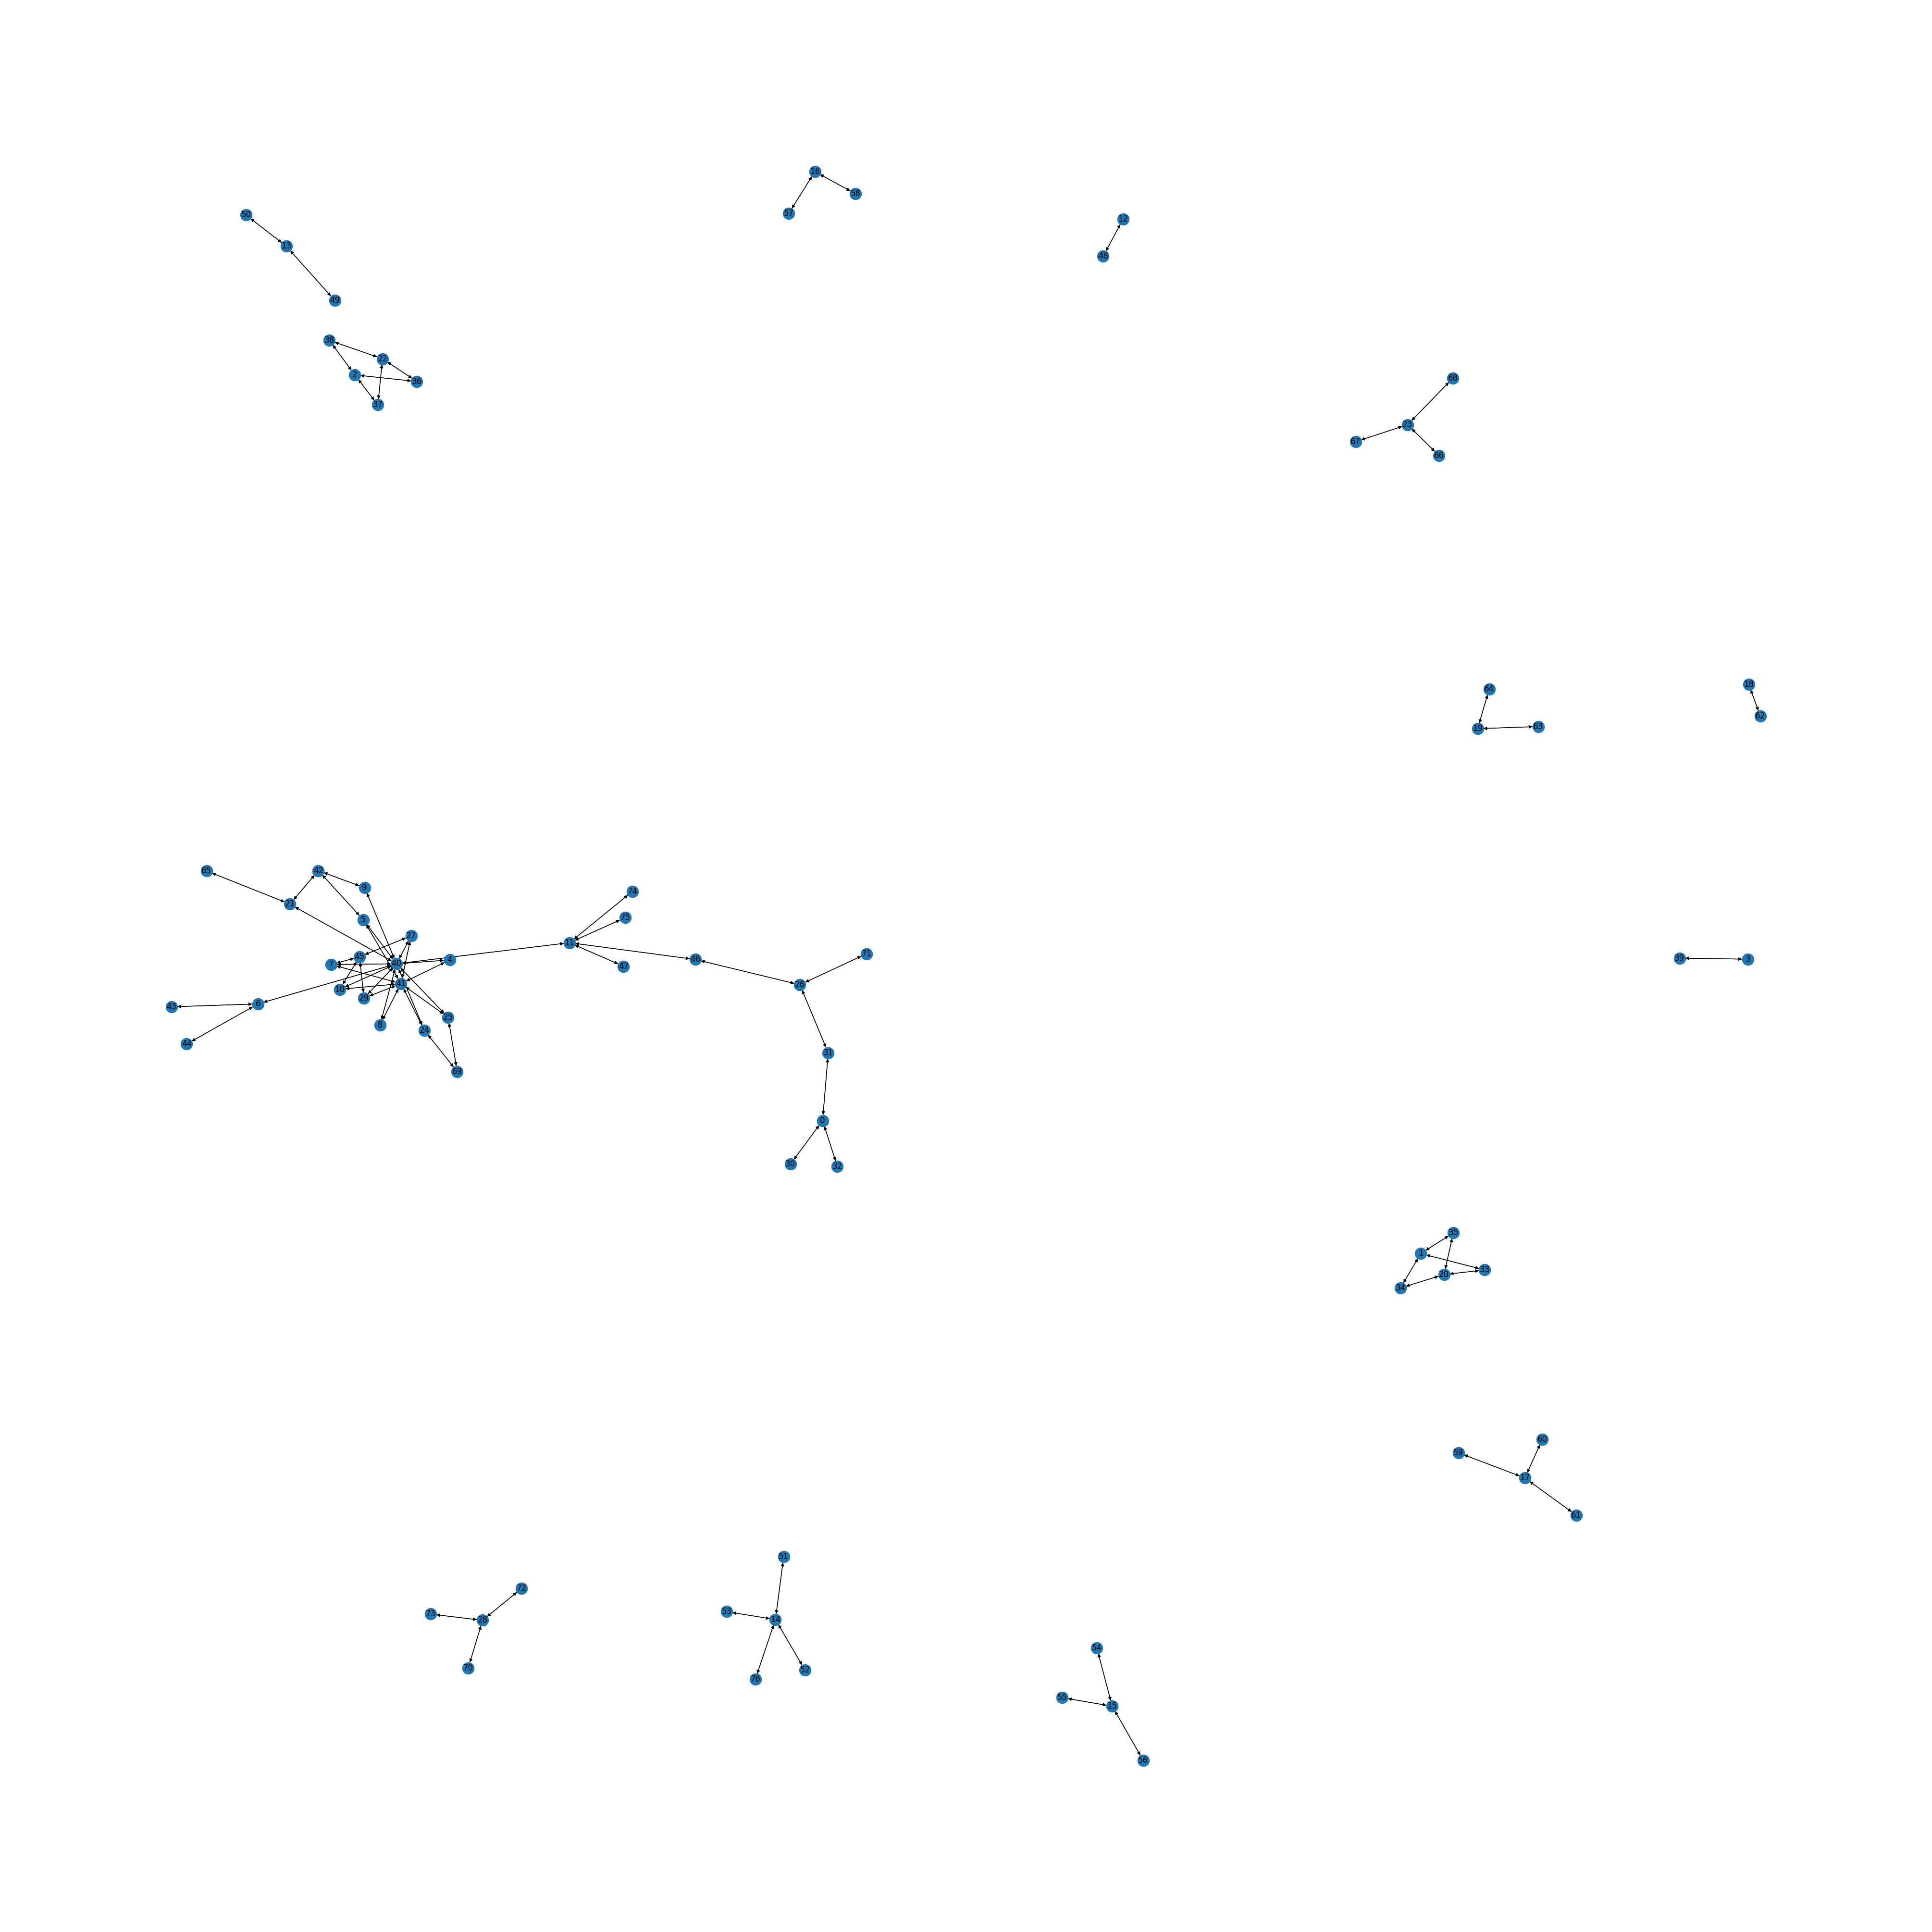

In [187]:
from torch_geometric.utils import to_networkx

nx_graph = to_networkx(graph_out.to_homogeneous())
pos_ug = nx.spring_layout(nx_graph)#, k=0.15, iterations=20)
plt.figure(figsize=(40,40))
nx.draw(nx_graph, pos_ug, with_labels=True)


Let's build a GNN

In [188]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, MeanAggregation, GATConv
from torch_geometric.nn import global_mean_pool


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv3 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin = Linear(hidden_channels, 2)
        self.softmax = torch.nn.Softmax(dim=1)
        self.pool = MeanAggregation()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = self.pool(x, batch)  # [batch_size, hidden_channels]

        #x = torch.concat([x, post_emb])
        # 3. Apply a final classifier
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #x = self.softmax(x)
        return x
model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv((-1, -1), 64, heads=1)
  (conv2): GATConv((-1, -1), 64, heads=1)
  (conv3): GATConv((-1, -1), 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (pool): MeanAggregation()
)


In [208]:
from torch_geometric.nn import HeteroConv


class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('tag', 'describes', 'question') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('tag', 'describes', 'answer') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('tag', 'describes', 'comment') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('module', 'imported_in', 'question') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('module', 'imported_in', 'answer') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('question', 'rev_describes', 'tag') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('answer', 'rev_describes', 'tag') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('comment', 'rev_describes', 'tag') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('question', 'rev_imported_in', 'module') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
                ('answer', 'rev_imported_in', 'module') : GATConv((-1,-1), hidden_channels, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, post_emb=2):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            # x_dict = conv(x_dict, edge_index_dict)
            # x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin(x_dict["question"])


hgnn = HeteroGNN(hidden_channels=64, out_channels=2, num_layers=3)
hgnn

HeteroGNN(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=10)
    (1): HeteroConv(num_relations=10)
    (2): HeteroConv(num_relations=10)
  )
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [209]:
hgnn(graph_out.x_dict, graph_out.edge_index_dict)

{'question': tensor([[-0.2140,  0.2582,  0.0418,  ..., -0.1911, -0.2429,  0.3171],
        [-0.5248, -0.3328, -0.1855,  ..., -0.3634, -0.5049,  0.4069],
        [-0.2781, -0.1446,  0.0836,  ..., -0.1911, -0.2429,  0.3171],
        ...,
        [-0.7625, -0.1555,  0.2546,  ..., -0.6277, -0.4404,  0.4829],
        [-0.5801, -0.1799,  0.0177,  ..., -0.7756, -0.3777,  0.6154],
        [-0.4816, -0.2273,  0.1792,  ..., -0.6507, -0.3987,  0.6613]],
       grad_fn=<IndexBackward0>), 'answer': tensor([[-0.4508, -0.0494, -0.1065,  ..., -0.7733, -0.4100,  0.5551],
        [-0.0320,  0.1107,  0.0685,  ..., -0.6227, -0.4434,  0.5157],
        [-0.2373,  0.0012, -0.3169,  ..., -0.1911, -0.2429,  0.3171],
        ...,
        [-0.6502, -0.1844, -0.1444,  ..., -0.1911, -0.2429,  0.3171],
        [-0.1791, -0.1900,  0.0217,  ..., -0.1911, -0.2429,  0.3171],
        [-0.4617, -0.3145,  0.0529,  ..., -0.1911, -0.2429,  0.3171]],
       grad_fn=<IndexBackward0>), 'comment': tensor([[-0.6725, -0.3506, -0.

tensor([[ 0.1383, -0.0523],
        [ 0.0960, -0.1694],
        [ 0.1789, -0.2487],
        [ 0.1488,  0.0771],
        [ 0.4119, -0.2283],
        [ 0.3236, -0.1978],
        [ 0.2544, -0.1003],
        [ 0.4439, -0.1998],
        [ 0.4119, -0.2283],
        [ 0.2338, -0.1747]], grad_fn=<AddmmBackward0>)

In [201]:
from torch_geometric.nn import to_hetero, to_hetero_with_bases

metadata = (['question', 'answer', 'comment', 'tag', 'module'], [('tag', 'describes', 'question'), ('tag', 'describes', 'answer'), ('tag', 'describes', 'comment'), ('module', 'imported_in', 'question'), ('module', 'imported_in', 'answer'), ('question', 'rev_describes', 'tag'), ('answer', 'rev_describes', 'tag'), ('comment', 'rev_describes', 'tag'), ('question', 'rev_imported_in', 'module'), ('answer', 'rev_imported_in', 'module')])
model = to_hetero_with_bases(model, metadata, num_bases=5)
model

TraceError: symbolically traced variables cannot be used as inputs to control flow

In [202]:
model(graph_out.x_dict, graph_out.edge_index_dict, graph_out.batch_dict)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1536 but got size 768 for tensor number 2 in the list.

In [ ]:
graph_out.edge_index_dict

In [ ]:
print("Question ndim:", graph_out.x_dict['question'].dim())
print("Answer ndim:", graph_out.x_dict['answer'].dim())
print("Comment ndim:", graph_out.x_dict['comment'].dim())
print("Tag ndim:", graph_out.x_dict['tag'].dim())
print("Module ndim:", graph_out.x_dict['module'].dim())